# Setup

In [1]:
import gym
import logging
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
print("TensorFlow Ver: ", tf.__version__)
print("Eager Execution:", tf.executing_eagerly())

TensorFlow Ver:  1.13.0-dev20190117
Eager Execution: True


In [4]:
# eager by default!
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


# Advantage Actor-Critic with TensorFlow 2.0

## Policy & Value Model Class

In [5]:
class ProbabilityDistribution(tf.keras.Model):
    def call(self, logits):
        # sample a random categorical action from given logits
        return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)

class Model(tf.keras.Model):
    def __init__(self, num_actions):
        super().__init__('mlp_policy')
        # no tf.get_variable(), just simple Keras API
        self.hidden1 = kl.Dense(128, activation='relu')
        self.hidden2 = kl.Dense(128, activation='relu')
        self.value = kl.Dense(1, name='value')
        # logits are unnormalized log probabilities
        self.logits = kl.Dense(num_actions, name='policy_logits')
        self.dist = ProbabilityDistribution()

    def call(self, inputs):
        # inputs is a numpy array, convert to Tensor
        x = tf.convert_to_tensor(inputs)
        # separate hidden layers from the same input tensor
        hidden_logs = self.hidden1(x)
        hidden_vals = self.hidden2(x)
        return self.logits(hidden_logs), self.value(hidden_vals)

    def action_value(self, obs):
        # executes call() under the hood
        logits, value = self.predict(obs)
        action = self.dist.predict(logits)
        # a simpler option, will become clear later why we don't use it
        # action = tf.random.categorical(logits, 1)
        return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)

## Advantage Actor-Critic Agent Class

In [6]:
class A2CAgent:
    def __init__(self, model):
        # hyperparameters for loss terms, gamma is the discount coefficient
        self.params = {
            'gamma': 0.99,
            'value': 0.5,
            'entropy': 0.0001
        }
        self.model = model
        self.model.compile(
            optimizer=ko.RMSprop(lr=0.0007),
            # define separate losses for policy logits and value estimate
            loss=[self._logits_loss, self._value_loss]
        )
    
    def train(self, env, batch_sz=32, updates=1000):
        # storage helpers for a single batch of data
        actions = np.empty((batch_sz,), dtype=np.int32)
        rewards, dones, values = np.empty((3, batch_sz))
        observations = np.empty((batch_sz,) + env.observation_space.shape)
        # training loop: collect samples, send to optimizer, repeat updates times
        ep_rews = [0.0]
        next_obs = env.reset()
        for update in range(updates):
            for step in range(batch_sz):
                observations[step] = next_obs.copy()
                actions[step], values[step] = self.model.action_value(next_obs[None, :])
                next_obs, rewards[step], dones[step], _ = env.step(actions[step])

                ep_rews[-1] += rewards[step]
                if dones[step]:
                    ep_rews.append(0.0)
                    next_obs = env.reset()
                    logging.info("Episode: %03d, Reward: %03d" % (len(ep_rews)-1, ep_rews[-2]))

            _, next_value = self.model.action_value(next_obs[None, :])
            returns, advs = self._returns_advantages(rewards, dones, values, next_value)
            # a trick to input actions and advantages through same API
            acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)
            # performs a full training step on the collected batch
            # note: no need to mess around with gradients, Keras API handles it
            losses = self.model.train_on_batch(observations, [acts_and_advs, returns])
            logging.debug("[%d/%d] Losses: %s" % (update+1, updates, losses))
        return ep_rews

    def test(self, env, render=False):
        obs, done, ep_reward = env.reset(), False, 0
        while not done:
            action, _ = self.model.action_value(obs[None, :])
            obs, reward, done, _ = env.step(action)
            ep_reward += reward
            if render:
                env.render()
        return ep_reward

    def _returns_advantages(self, rewards, dones, values, next_value):
        # next_value is the bootstrap value estimate of a future state (the critic)
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # returns are calculated as discounted sum of future rewards
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.params['gamma'] * returns[t+1] * (1-dones[t])
        returns = returns[:-1]
        # advantages are returns - baseline, value estimates in our case
        advantages = returns - values
        return returns, advantages
    
    def _value_loss(self, returns, value):
        # value loss is typically MSE between value estimates and returns
        return self.params['value']*kls.mean_squared_error(returns, value)

    def _logits_loss(self, acts_and_advs, logits):
        # a trick to input actions and advantages through same API
        actions, advantages = tf.split(acts_and_advs, 2, axis=-1)
        # polymorphic CE loss function that supports sparse and weighted options
        # from_logits argument ensures transformation into normalized probabilities
        cross_entropy = kls.CategoricalCrossentropy(from_logits=True)
        # policy loss is defined by policy gradients, weighted by advantages
        # note: we only calculate the loss on the actions we've actually taken
        # thus under the hood a sparse version of CE loss will be executed
        actions = tf.cast(actions, tf.int32)
        policy_loss = cross_entropy(actions, logits, sample_weight=advantages)
        # entropy loss can be calculated via CE over itself
        entropy_loss = cross_entropy(logits, logits)
        # here signs are flipped because optimizer minimizes
        return policy_loss - self.params['entropy']*entropy_loss

In [7]:
env = gym.make('CartPole-v0')
model = Model(num_actions=env.action_space.n)
model.action_value(env.reset()[None, :])

Instructions for updating:
Colocations handled automatically by placer.


(array(1), array([0.00197717], dtype=float32))

# Training A2C Agent & Results

In [8]:
env = gym.make('CartPole-v0')
model = Model(num_actions=env.action_space.n)
agent = A2CAgent(model)

## Testing with Random Weights

In [9]:
rewards_sum = agent.test(env)
print("Total Episode Reward: %d out of 200" % agent.test(env))

Total Episode Reward: 12 out of 200


In [10]:
# set to logging.WARNING to disable logs or logging.DEBUG to see losses as well
logging.basicConfig(level=logging.INFO)

rewards_history = agent.train(env)
print("Finished training.")

INFO:root:Episode: 001, Reward: 019
INFO:root:Episode: 002, Reward: 023
INFO:root:Episode: 003, Reward: 027
INFO:root:Episode: 004, Reward: 016
INFO:root:Episode: 005, Reward: 035
INFO:root:Episode: 006, Reward: 021
INFO:root:Episode: 007, Reward: 012
INFO:root:Episode: 008, Reward: 023
INFO:root:Episode: 009, Reward: 021
INFO:root:Episode: 010, Reward: 026
INFO:root:Episode: 011, Reward: 059
INFO:root:Episode: 012, Reward: 021
INFO:root:Episode: 013, Reward: 012
INFO:root:Episode: 014, Reward: 018
INFO:root:Episode: 015, Reward: 016
INFO:root:Episode: 016, Reward: 027
INFO:root:Episode: 017, Reward: 032
INFO:root:Episode: 018, Reward: 013
INFO:root:Episode: 019, Reward: 017
INFO:root:Episode: 020, Reward: 041
INFO:root:Episode: 021, Reward: 015
INFO:root:Episode: 022, Reward: 015
INFO:root:Episode: 023, Reward: 045
INFO:root:Episode: 024, Reward: 014
INFO:root:Episode: 025, Reward: 018
INFO:root:Episode: 026, Reward: 037
INFO:root:Episode: 027, Reward: 017
INFO:root:Episode: 028, Rewa

INFO:root:Episode: 229, Reward: 026
INFO:root:Episode: 230, Reward: 054
INFO:root:Episode: 231, Reward: 120
INFO:root:Episode: 232, Reward: 074
INFO:root:Episode: 233, Reward: 122
INFO:root:Episode: 234, Reward: 098
INFO:root:Episode: 235, Reward: 034
INFO:root:Episode: 236, Reward: 086
INFO:root:Episode: 237, Reward: 126
INFO:root:Episode: 238, Reward: 200
INFO:root:Episode: 239, Reward: 175
INFO:root:Episode: 240, Reward: 059
INFO:root:Episode: 241, Reward: 045
INFO:root:Episode: 242, Reward: 029
INFO:root:Episode: 243, Reward: 027
INFO:root:Episode: 244, Reward: 128
INFO:root:Episode: 245, Reward: 104
INFO:root:Episode: 246, Reward: 133
INFO:root:Episode: 247, Reward: 101
INFO:root:Episode: 248, Reward: 043
INFO:root:Episode: 249, Reward: 053
INFO:root:Episode: 250, Reward: 065
INFO:root:Episode: 251, Reward: 072
INFO:root:Episode: 252, Reward: 093
INFO:root:Episode: 253, Reward: 200
INFO:root:Episode: 254, Reward: 156
INFO:root:Episode: 255, Reward: 053
INFO:root:Episode: 256, Rewa

Finished training.


## Testing with Trained Model

In [11]:
print("Total Episode Reward: %d out of 200" % agent.test(env))

Total Episode Reward: 200 out of 200


## Training Rewards History

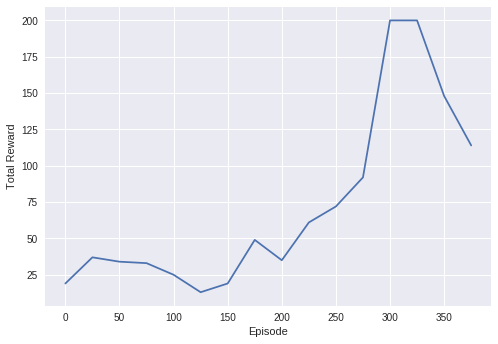

In [12]:
plt.style.use('seaborn')
plt.plot(np.arange(0, len(rewards_history), 25), rewards_history[::25])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Static Computational Graph

In [13]:
with tf.Graph().as_default():
    print("Eager Execution:", tf.executing_eagerly()) # False

    model = Model(num_actions=env.action_space.n)
    agent = A2CAgent(model)

    rewards_history = agent.train(env)
    print("Finished training, testing...")
    print("Total Episode Reward: %d out of 200" % agent.test(env))

Eager Execution: False
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:root:Episode: 001, Reward: 020


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:root:Episode: 002, Reward: 027
INFO:root:Episode: 003, Reward: 032
INFO:root:Episode: 004, Reward: 017
INFO:root:Episode: 005, Reward: 012
INFO:root:Episode: 006, Reward: 015
INFO:root:Episode: 007, Reward: 025
INFO:root:Episode: 008, Reward: 010
INFO:root:Episode: 009, Reward: 026
INFO:root:Episode: 010, Reward: 014
INFO:root:Episode: 011, Reward: 054
INFO:root:Episode: 012, Reward: 012
INFO:root:Episode: 013, Reward: 038
INFO:root:Episode: 014, Reward: 024
INFO:root:Episode: 015, Reward: 022
INFO:root:Episode: 016, Reward: 034
INFO:root:Episode: 017, Reward: 072
INFO:root:Episode: 018, Reward: 022
INFO:root:Episode: 019, Reward: 029
INFO:root:Episode: 020, Reward: 020
INFO:root:Episode: 021, Reward: 017
INFO:root:Episode: 022, Reward: 013
INFO:root:Episode: 023, Reward: 067
INFO:root:Episode: 024, Reward: 100
INFO:root:Episode: 025, Reward: 056
INFO:root:Episode:

INFO:root:Episode: 219, Reward: 069
INFO:root:Episode: 220, Reward: 164
INFO:root:Episode: 221, Reward: 054
INFO:root:Episode: 222, Reward: 061
INFO:root:Episode: 223, Reward: 090
INFO:root:Episode: 224, Reward: 109
INFO:root:Episode: 225, Reward: 161
INFO:root:Episode: 226, Reward: 200
INFO:root:Episode: 227, Reward: 062
INFO:root:Episode: 228, Reward: 059
INFO:root:Episode: 229, Reward: 102
INFO:root:Episode: 230, Reward: 181
INFO:root:Episode: 231, Reward: 031
INFO:root:Episode: 232, Reward: 107
INFO:root:Episode: 233, Reward: 037
INFO:root:Episode: 234, Reward: 113
INFO:root:Episode: 235, Reward: 102
INFO:root:Episode: 236, Reward: 029
INFO:root:Episode: 237, Reward: 023
INFO:root:Episode: 238, Reward: 145
INFO:root:Episode: 239, Reward: 062
INFO:root:Episode: 240, Reward: 068
INFO:root:Episode: 241, Reward: 157
INFO:root:Episode: 242, Reward: 073
INFO:root:Episode: 243, Reward: 077
INFO:root:Episode: 244, Reward: 146
INFO:root:Episode: 245, Reward: 067
INFO:root:Episode: 246, Rewa

Finished training, testing...
Total Episode Reward: 200 out of 200


# Benchmarks

In [18]:
# Note: comparing wall time isn't exactly fair due to specifics of how things are executed on multi-core CPU

In [14]:
env = gym.make('CartPole-v0')
obs = np.repeat(env.reset()[None, :], 100000, axis=0)

## Eager Benchmark

In [15]:
%%time

model = Model(env.action_space.n)
model.run_eagerly = True

print("Eager Execution:  ", tf.executing_eagerly())
print("Eager Keras Model:", model.run_eagerly)

_ = model(obs)
# _ = model.predict(obs)

Eager Execution:   True
Eager Keras Model: True
CPU times: user 639 ms, sys: 736 ms, total: 1.38 s
Wall time: 116 ms


## Static Benchmark

In [16]:
%%time

with tf.Graph().as_default():
    model = Model(env.action_space.n)

    print("Eager Execution:  ", tf.executing_eagerly())
    print("Eager Keras Model:", model.run_eagerly)

    _ = model.predict(obs)

Eager Execution:   False
Eager Keras Model: False
CPU times: user 793 ms, sys: 79.7 ms, total: 873 ms
Wall time: 656 ms


## Default Benchmark

In [17]:
%%time

model = Model(env.action_space.n)

print("Eager Execution:  ", tf.executing_eagerly())
print("Eager Keras Model:", model.run_eagerly)

_ = model.predict(obs)

Eager Execution:   True
Eager Keras Model: False
CPU times: user 994 ms, sys: 23.1 ms, total: 1.02 s
Wall time: 769 ms
